In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pytz
import os
import patsy #for spline regression
import scipy #for non-negative least square 
import scipy as sp 
from scipy import stats
from scipy.optimize import nnls
from numpy.linalg import inv #for matrix and statistics
import scipy as sp
import math
import statsmodels.api as sm
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import sklearn.cluster
import sklearn.linear_model
%matplotlib inline

In [125]:
#specify data source 
datasource = 'LocusEnergy'

In [126]:
zipcode = '08641'

In [127]:
#mainDir = 'C:/Users/umnouyp/Dropbox/Active/EnergyProject/Thesis/PVreadingsStudies/main'
#mainDir = 'C:/Users/Tee/Dropbox/Active/EnergyProject/Thesis/PVreadingsStudies/main'
mainDir = 'C:\Users\Admin\Dropbox\Active\EnergyProject\Thesis\PVreadingsStudies\main'
#we can choose which data to look at.
dataDir = mainDir + '/data/' + datasource +'/' + zipcode +'/'
outputDir = mainDir + '/output/'+ datasource +'/' + zipcode +'/'

In [128]:
data = pd.read_csv(dataDir +'/training_data_fitted.csv')
data['tsLocal'] = data['tsLocal'].map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

dsummary = pd.read_csv(outputDir+"/fitsummary.csv")
dsummary.Date = dsummary.Date.map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d").date())
FullModelCoef = pd.read_csv(outputDir+"/FullModelCoef.csv")

In [129]:
dsummary[:1]

,E,Rsq,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,Date,DBW,singlemax,PeakCheck,FirstCheck,SecondCheck,mE
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-01-01,-355,NaN,False,False,False,5.070652


In [130]:
FullModelCoef[:1]

,DBW,c1,c2,c3,c4,c5,c6,c7,c8,c9,c0,c10
0,0,0.435674,0.52322,0.750568,0.761555,0.794036,0.838259,0.83471,0.657754,0.646756,0.156387,0.156051


Here we define power ratio, $r$, for each power reading. We add shift to avoid infinity.

In [131]:
shift = 0.01
data['r'] = (data.power+shift)/(data.mpower+shift)

In [132]:
data[:1]

,tsLocal,altitude,azimuth,power,numactivecomp,totalsize,s,DBW,mpower,r
0,2013-01-01 07:30:00,1.11014,-301.362934,NaN,5,64.71819,-0.999743,-355,0.154078,NaN


# Basic time series construction with hourly volatility

Here we construct time series of power and power ratio. We add time without sun to create consistent time series. In addition, we add parallel values of previous 15 minute instances (-1, -2, ...) and previous day instances (y).

In [133]:
#specify scope
StartScopeDate = '2013-01-01'
EndScopeDate = '2015-01-01'
StartScopeTime =  datetime.datetime.strptime(StartScopeDate,"%Y-%m-%d")
EndScopeTime =  datetime.datetime.strptime(EndScopeDate,"%Y-%m-%d")

#Generate data frame from start to end for time series
tslist = []
nxt = StartScopeTime
while nxt < EndScopeTime:
    tslist.append(nxt)
    nxt += datetime.timedelta(minutes=15)
    
Scope = pd.DataFrame(0, index = np.arange(len(tslist)), columns = ['tsLocal'])
Scope['tsLocal'] = tslist

#Now we can merge using Scope Table as a backbone of data structure.
d = pd.merge(Scope,data,on=['tsLocal'], how = 'left') 

In [134]:
#timeseries of previous timestamps
d['power-1'] = float('NaN')
d['mpower-1'] = float('NaN')
d['mpower-2'] = float('NaN')
d['mpower-3'] = float('NaN')
d['mpower-4'] = float('NaN')
d['power-2'] = float('NaN')
d['power-3'] = float('NaN')
d['power-4'] = float('NaN')
d['power-5'] = float('NaN')
d['power-6'] = float('NaN')
d['power_y-0'] = float('NaN')
d['power_y-1'] = float('NaN')
d['power_y-2'] = float('NaN')
d['r-1'] = float('NaN')
d['r-2'] = float('NaN')
d['r-3'] = float('NaN')
d['r-4'] = float('NaN')
d['r-5'] = float('NaN')
d['r-6'] = float('NaN')
d['r_y-0'] = float('NaN')
d['r_y-1'] = float('NaN')
d['r_y-2'] = float('NaN')
d.loc[1:d.shape[0],'r-1'] = list(d['r'].iloc[0:(d.shape[0]-1)])
d.loc[2:d.shape[0],'r-2'] = list(d['r'].iloc[0:(d.shape[0]-2)])
d.loc[3:d.shape[0],'r-3'] = list(d['r'].iloc[0:(d.shape[0]-3)])
d.loc[4:d.shape[0],'r-4'] = list(d['r'].iloc[0:(d.shape[0]-4)])
d.loc[5:d.shape[0],'r-5'] = list(d['r'].iloc[0:(d.shape[0]-5)])
d.loc[6:d.shape[0],'r-6'] = list(d['r'].iloc[0:(d.shape[0]-6)])
d.loc[1:d.shape[0],'mpower-1'] = list(d['mpower'].iloc[0:(d.shape[0]-1)])
d.loc[2:d.shape[0],'mpower-2'] = list(d['mpower'].iloc[0:(d.shape[0]-2)])
d.loc[3:d.shape[0],'mpower-3'] = list(d['mpower'].iloc[0:(d.shape[0]-3)])
d.loc[4:d.shape[0],'mpower-4'] = list(d['mpower'].iloc[0:(d.shape[0]-4)])
d.loc[1:d.shape[0],'power-1'] = list(d['power'].iloc[0:(d.shape[0]-1)])
d.loc[2:d.shape[0],'power-2'] = list(d['power'].iloc[0:(d.shape[0]-2)])
d.loc[3:d.shape[0],'power-3'] = list(d['power'].iloc[0:(d.shape[0]-3)])
d.loc[4:d.shape[0],'power-4'] = list(d['power'].iloc[0:(d.shape[0]-4)])
d.loc[5:d.shape[0],'power-5'] = list(d['power'].iloc[0:(d.shape[0]-5)])
d.loc[6:d.shape[0],'power-6'] = list(d['power'].iloc[0:(d.shape[0]-6)])

#24 hour shift = 24*4 shift in index. 'y' means yesterday
d.loc[96:d.shape[0],'r_y-0'] = list(d['r'].iloc[0:(d.shape[0]-96)])
d.loc[96:d.shape[0],'r_y-1'] = list(d['r-1'].iloc[0:(d.shape[0]-96)])
d.loc[96:d.shape[0],'r_y-2'] = list(d['r-2'].iloc[0:(d.shape[0]-96)])
d.loc[96:d.shape[0],'r_y-3'] = list(d['r-3'].iloc[0:(d.shape[0]-96)])
d.loc[96:d.shape[0],'r_y-4'] = list(d['r-4'].iloc[0:(d.shape[0]-96)])
d.loc[96:d.shape[0],'power_y-0'] = list(d['power'].iloc[0:(d.shape[0]-96)])
d.loc[96:d.shape[0],'power_y-1'] = list(d['power-1'].iloc[0:(d.shape[0]-96)])
d.loc[96:d.shape[0],'power_y-2'] = list(d['power-2'].iloc[0:(d.shape[0]-96)])
d.loc[96:d.shape[0],'power_y-3'] = list(d['power-3'].iloc[0:(d.shape[0]-96)])
d.loc[96:d.shape[0],'power_y-4'] = list(d['power-4'].iloc[0:(d.shape[0]-96)])

Let's compute rolling hourly volaitility (this is for 15 min interval)

In [135]:
#volatility derivative-based and persistence-based
d['V-d'] = np.absolute(d['power-1']-4*d['power-2']+6*d['power-3']-4*d['power-4']+d['power-5'])
d['V-s'] = np.absolute(d['power-1']-d['power-2']/d['mpower-2']*d['mpower-1'])+\
            np.absolute(d['power-2']-d['power-3']/d['mpower-3']*d['mpower-2'])+\
             np.absolute(d['power-3']-d['power-4']/d['mpower-4']*d['mpower-3'])

Here we separate data for training and testing. Need this for autoregressive model.

In [136]:
Data = d
#select data for training and test
StartDate = datetime.date(2014,10,1)
TrainData = d[d.tsLocal.map(lambda x: x.date()) <StartDate].set_index('tsLocal')
TrainDateList = list(dsummary.Date[dsummary.Date<StartDate])
TestData = d[d.tsLocal.map(lambda x: x.date()) >=StartDate].set_index('tsLocal')

#Extra screening by high energy days
HighEnergyDayList = list(dsummary.Date[dsummary.E/dsummary.mE>0.9]) #for NJ
HighEnergyTestData = d[d.tsLocal.map(lambda x: (x.date()>=StartDate) & (x.date() in HighEnergyDayList))].set_index('tsLocal')

Before moving on, let's show that there is no poor correlation between 24 hour apart value.

In [137]:
from sklearn import datasets, linear_model
# Create linear regression object
regr1 = linear_model.LinearRegression()
regr2 = linear_model.LinearRegression()
check = d[['power','power_y-0','r','r_y-0']].dropna()

# Train the model using the training sets
regr1.fit(check[['power']], check[['power_y-0']])
regr2.fit(check[['r']], check[['r_y-0']])
[regr1.score(check[['power']], check[['power_y-0']]),regr2.score(check[['r']], check[['r_y-0']])]

[0.39077765150704846, 0.10867942244298012]

So we don't need to refer to previous 24 hours value.

Let's look at the color map of normalized power and r

(350, 750)

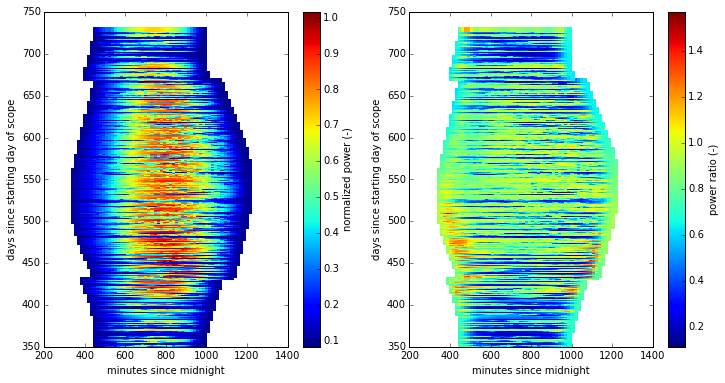

In [138]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import pylab
Ref = d.tsLocal.iloc[0].date()
x = d.tsLocal.map(lambda x: x.hour*60 + x.minute)
y = d.tsLocal.map(lambda x: (x.date()-Ref).days)
plt.clf()
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121)
plt.scatter(x, y, c= d.power, edgecolors='none',marker=',',s=20)
ax1.set_xlabel('minutes since midnight')
ax1.set_ylabel('days since starting day of scope')
cbar = plt.colorbar(ax=ax1)
cbar.ax.set_ylabel('normalized power (-)')
ax1.set_ylim(350,750)

ax1 = fig.add_subplot(122)
plt.scatter(x, y, c= d.r, edgecolors='none',marker=',',s=20)
ax1.set_xlabel('minutes since midnight')
ax1.set_ylabel('days since starting day of scope')
cbar = plt.colorbar(ax=ax1)
cbar.ax.set_ylabel('power ratio (-)')
ax1.set_ylim(350,750)


#15-minute rolling prediction: Naive model and auto-regression

Here we are interested in prediction between 8 am to 4 pm (minute 480-960)

## Model I: Naive model: current value equals to previous 15 min value

This is a reference.

In [139]:
d = Data
d = d[d.tsLocal.map(lambda x: ((x.hour*60 + x.minute)>=480) \
                                                         &((x.hour*60 + x.minute)<960)\
                                                 #&(x.date() in HighEnergyDayList) \
                                                )]


feature_names = ['r-1','power-1']
d = d.loc[:,['tsLocal','power','mpower','r','V-d','V-s']+feature_names].dropna()

In [140]:
#actual power
d['r_predict'] = float('NaN')
d['power_predict'] = float('NaN')
d['power_predict'] = d['power-1']
l = d['power']-d['power_predict']
l = l.reset_index(drop=True)

#Selected ten percent to report
#idx = np.random.permutation(len(l))
#l = [l[i] for i in idx]
#offset = int(len(l) * 0.9)
#l = l[offset:]

[np.mean(np.absolute(l)),np.max(np.absolute(l))]

[0.044596656686388181, 0.54609848509432735]

In [141]:
#actual r
d['r_predict'] = float('NaN')
d['power_predict'] = float('NaN')
d['r_predict'] = d['r-1']
d['power_predict'] = d.r_predict*(d.mpower+shift)-shift
l = d['power']-d['power_predict']
l = l.reset_index(drop=True)

#Option: Select ten percent to report
#idx = np.random.permutation(len(l))
#l = [l[i] for i in idx]
#offset = int(len(l) * 0.9)
#l = l[offset:]

[np.mean(np.absolute(l)),np.max(np.absolute(l))]

[0.038448581855029307, 0.55208729151762514]

Here one can see that 'r' has an advantage over 'power' and it makes sense with assumption of the status-quo.

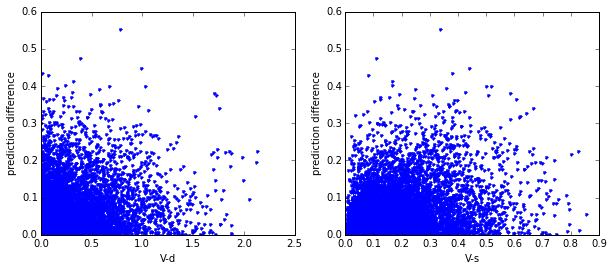

In [142]:
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
plt.plot(d['V-d'],np.absolute(d.power-d.power_predict),'.')
plt.xlabel('V-d')
plt.ylabel('prediction difference')
ax1 = fig.add_subplot(122)
plt.plot(d['V-s'],np.absolute(d.power-d.power_predict),'.')
plt.xlabel('V-s')
plt.ylabel('prediction difference')

## Model II: Slightly naive model: current value equals to extrapolation of previous 15 min and 30 min values

In [143]:
d = Data
d = d[d.tsLocal.map(lambda x: ((x.hour*60 + x.minute)>=480) \
                                                         &((x.hour*60 + x.minute)<960)\
                                                 #&(x.date() in HighEnergyDayList) \
                                                )]


feature_names = ['r-1','r-2','power-1','power-2']
d = d.loc[:,['tsLocal','power','mpower','r','V-d','V-s']+feature_names].dropna()

In [144]:
#actual power
d['r_predict'] = float('NaN')
d['power_predict'] = float('NaN')
d['power_predict'] = 2*d['power-1'] - d['power-2']
l = d['power']-d['power_predict']

[np.mean(np.absolute(l)),np.max(np.absolute(l))]

[0.054598613469667386, 0.67239746219998975]

In [145]:
#actual r
d['r_predict'] = float('NaN')
d['power_predict'] = float('NaN')
d['r_predict'] = 2*d['r-1'] - d['r-2']
d['power_predict'] = d.r_predict*(d.mpower+shift)-shift
l = d['power']-d['power_predict']

[np.mean(np.absolute(l)),np.max(np.absolute(l))]

[0.055269480391589521, 0.68351094894599584]

Extrapolation fails.

## Model III: Moving Average

In [146]:
#Actual power
d = Data
d = d[d.tsLocal.map(lambda x: ((x.hour*60 + x.minute)>=480) \
                                                         &((x.hour*60 + x.minute)<960)\
                                                 #&(x.date() in HighEnergyDayList) \
                                                )]

feature_names = ['power-1','power-2','power-3','power-4']
d = d.loc[:,['tsLocal','power','mpower','r','V-d','V-s']+feature_names].dropna()

#actual power
d['r_predict'] = float('NaN')
d['power_predict'] = float('NaN')
d['power_predict'] =  0.25*(d['power-1']+d['power-2']+d['power-3']+d['power-4'])
l = d['power']-d['power_predict']

[np.mean(np.absolute(l)),np.max(np.absolute(l))]


[0.068186937690288829, 0.547917747753354]

In [147]:
#Actual r
d = Data
d = d[d.tsLocal.map(lambda x: ((x.hour*60 + x.minute)>=480) \
                                                         &((x.hour*60 + x.minute)<960)\
                                                 #&(x.date() in HighEnergyDayList) \
                                                )]

#feature_names = ['r-1','r-2','r-3','r-4']
#feature_names = ['r-1','r-2','r-3']
feature_names = ['r-1','r-2']
d = d.loc[:,['tsLocal','power','mpower','r','V-d','V-s']+feature_names].dropna()

#actual power
d['r_predict'] = float('NaN')
d['power_predict'] = float('NaN')
#d['r_predict'] =  (d['r-1']+d['r-2']+d['r-3']+d['r-4'])/4
#d['r_predict'] =  (d['r-1']+d['r-2']+d['r-3'])/3
d['r_predict'] =  (d['r-1']+d['r-2'])/2
d['power_predict'] = d.r_predict*(d.mpower+shift)-shift
l = d['power']-d['power_predict']

[np.mean(np.absolute(l)),np.max(np.absolute(l))]


[0.042274507877723133, 0.51435381114258738]

It turns out that the more you add, the poorer the performance is.

## Model IV: current value is autoregression of previous 15 min value

In [148]:
#Actual power
d = Data
d = d[d.tsLocal.map(lambda x: ((x.hour*60 + x.minute)>=480) \
                                                         &((x.hour*60 + x.minute)<960)\
                                                 #&(x.date() in HighEnergyDayList) \
                                                )]

feature_names = ['power-1']
d = d.loc[:,['tsLocal','power','mpower','r','V-d','V-s']+feature_names].dropna()

#Truly random
l = np.random.permutation(d.shape[0])
d = d.iloc[l].reset_index(drop=True)
offset = int(d.shape[0] * 0.9)

#Assign specific period
#StartDate = datetime.date(2014,10,1)
#offset = d[d.tsLocal.map(lambda x: x.date()) <StartDate].shape[0]

X_train, y_train = d[:offset].loc[:,feature_names], d[:offset].loc[:,'power']
X_test, y_test = d[offset:].loc[:,feature_names], d[offset:].loc[:,'power']

mod = sklearn.linear_model.LinearRegression().fit(X_train,y_train)
l = y_test-mod.predict(X_test)
[np.mean(np.absolute(l)),np.max(np.absolute(l))]

[0.045327596606966475, 0.37096632461077012]

In [149]:
#actual r
d = Data
d = d[d.tsLocal.map(lambda x: ((x.hour*60 + x.minute)>=480) \
                                                         &((x.hour*60 + x.minute)<960)\
                                                 #&(x.date() in HighEnergyDayList) \
                                                )]

feature_names = ['r-1']
d = d.loc[:,['tsLocal','power','mpower','r','V-d','V-s']+feature_names].dropna()

#Truly random
l = np.random.permutation(d.shape[0])
d = d.iloc[l].reset_index(drop=True)
offset = int(d.shape[0] * 0.9)

#Assign specific period
#StartDate = datetime.date(2014,10,1)
#offset = d[d.tsLocal.map(lambda x: x.date()) <StartDate].shape[0]

X_train, y_train = d[:offset].loc[:,feature_names], d[:offset].loc[:,'r']
X_test, y_test = d[offset:].loc[:,feature_names], d[offset:].loc[:,'r']

mod = sklearn.linear_model.LinearRegression().fit(X_train,y_train)
l = d[offset:]['power']-(mod.predict(X_test)*(d[offset:].mpower+shift)-shift)
[np.mean(np.absolute(l)),np.max(np.absolute(l))]


[0.039728115120124724, 0.36497971477914354]

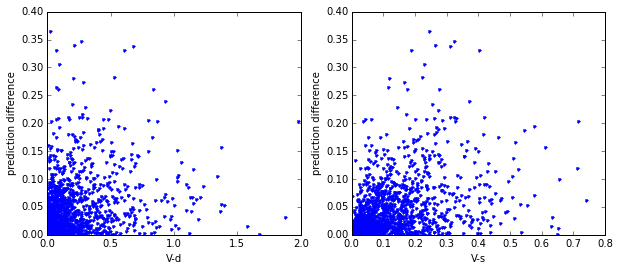

In [150]:
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
plt.plot(d[offset:]['V-d'],np.absolute(l),'.')
plt.xlabel('V-d')
plt.ylabel('prediction difference')
ax1 = fig.add_subplot(122)
plt.plot(d[offset:]['V-s'],np.absolute(l),'.')
plt.xlabel('V-s')
plt.ylabel('prediction difference')

Autoregression performs worse than most naive (forcing coefficient to be 1)!?! This is possibly because overfitting?

## Model V: current value is autoregression of previous 15 and 30 min values.

In [151]:
#Actual power
d = Data
d = d[d.tsLocal.map(lambda x: ((x.hour*60 + x.minute)>=480) \
                                                         &((x.hour*60 + x.minute)<960)\
                                                 #&(x.date() in HighEnergyDayList) \
                                                )]

feature_names = ['power-1','power-2']
d = d.loc[:,['tsLocal','power','mpower','r','V-d','V-s']+feature_names].dropna()

#Truly random
l = np.random.permutation(d.shape[0])
d = d.iloc[l].reset_index(drop=True)
offset = int(d.shape[0] * 0.9)

#Assign specific period
#StartDate = datetime.date(2014,10,1)
#offset = d[d.tsLocal.map(lambda x: x.date()) <StartDate].shape[0]

X_train, y_train = d[:offset].loc[:,feature_names], d[:offset].loc[:,'power']
X_test, y_test = d[offset:].loc[:,feature_names], d[offset:].loc[:,'power']

mod = sklearn.linear_model.LinearRegression().fit(X_train,y_train)
l = y_test-mod.predict(X_test)
[np.mean(np.absolute(l)),np.max(np.absolute(l))]


[0.044082863147476649, 0.3778626252672535]

In [152]:
#actual r
d = Data
d = d[d.tsLocal.map(lambda x: ((x.hour*60 + x.minute)>=480) \
                                                         &((x.hour*60 + x.minute)<960)\
                                                 #&(x.date() in HighEnergyDayList) \
                                                )]

feature_names = ['r-1','r-2']
d = d.loc[:,['tsLocal','power','mpower','r','V-d','V-s']+feature_names].dropna()

#Truly random
l = np.random.permutation(d.shape[0])
d = d.iloc[l].reset_index(drop=True)
offset = int(d.shape[0] * 0.9)

#Assign specific period
#StartDate = datetime.date(2014,10,1)
#offset = d[d.tsLocal.map(lambda x: x.date()) <StartDate].shape[0]

X_train, y_train = d[:offset].loc[:,feature_names], d[:offset].loc[:,'r']
X_test, y_test = d[offset:].loc[:,feature_names], d[offset:].loc[:,'r']

mod = sklearn.linear_model.LinearRegression().fit(X_train,y_train)
l = d[offset:]['power']-(mod.predict(X_test)*(d[offset:].mpower+shift)-shift)
[np.mean(np.absolute(l)),np.max(np.absolute(l))]


[0.040293460419395084, 0.53659676507439746]

Model V is more or less similar to Model IV. Model V is usually better in term of average error but not maximum error. Still, it does not beat the most naive model.

## Intermission summary

So far, no method beats status-quo on r yet. Note that this result is set for minute 480 to 960 only. If we extend this to all minutes. We have slightly lower errors. That means status-quo on r applies better or the error tends to be small in those regions and gives overall lower errors.

In [153]:
#actual r
d = Data
#d = d[d.tsLocal.map(lambda x: ((x.hour*60 + x.minute)>=480 &((x.hour*60 + x.minute)<960)\
                                                 #&(x.date() in HighEnergyDayList) \
#                                                )]

feature_names = ['r-1','r-2']
d = d.loc[:,['tsLocal','power','mpower','r','V-d','V-s']+feature_names].dropna()

#actual r
d['r_predict'] = float('NaN')
d['power_predict'] = float('NaN')
d['r_predict'] = d['r-1']
d['power_predict'] = d.r_predict*(d.mpower+shift)-shift
l = d['power']-d['power_predict']
l = l.reset_index(drop=True)

#Option: Select ten percent to report
#idx = np.random.permutation(len(l))
#l = [l[i] for i in idx]
#offset = int(len(l) * 0.9)
#l = l[offset:]

[np.mean(np.absolute(l)),np.max(np.absolute(l))]


[0.035659484560903114, 0.55208729151762514]

(350, 750)

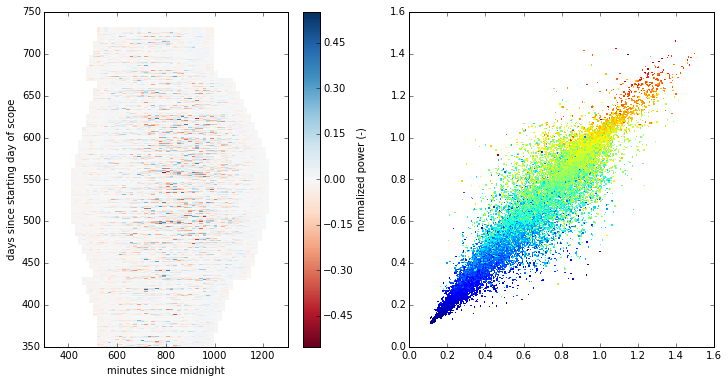

In [154]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import pylab
Ref = Data.tsLocal.iloc[0].date()
x = d.tsLocal.map(lambda x: x.hour*60 + x.minute)
y = d.tsLocal.map(lambda x: (x.date()-Ref).days)
plt.clf()
fig = plt.figure(figsize=(12, 6))
c = (d['power']-(d['r-1']*(d.mpower+shift)-shift))
maxc = np.max(np.absolute(c))

ax1 = fig.add_subplot(122)
#plt.plot(d['r-1'],d['r'],'.')
plt.scatter(d['r-2'],d['r-1'], c= d['r'], edgecolors='none',marker=',',s=2)

ax1 = fig.add_subplot(121)
plt.scatter(x, y, c= c, edgecolors='none',\
            cmap = 'RdBu',marker=',',s=20, vmin=-maxc, vmax= maxc)
ax1.set_xlabel('minutes since midnight')
ax1.set_ylabel('days since starting day of scope')
cbar = plt.colorbar(ax=ax1)
cbar.ax.set_ylabel('normalized power (-)')
ax1.set_ylim(350,750)


The second plot shows promising (?) contribution from r-2. Non-linear model might improve even more. The fact that status-quo model beats all means we need to more attributes or more sophisticated model than linear ones.

Note: models below are ones we have tried yet there is not much improvement due to what we have discussed: weak dependence in previous 30 mins or more and no clear signature from hour of a day and day of a year.

#STOP HERE

In [155]:
'

SyntaxError: EOL while scanning string literal (<ipython-input-155-ff4c069b4aa0>, line 1)

## Model: Hourly linear regression

In [ ]:
d = TestData.reset_index()
#actual power
d['r_predict'] = float('NaN')
d['power_predict'] = float('NaN')
d['beta'] = float('NaN')
d['beta'] =-(d['power-1']+2*d['power-2']+3*d['power-3']+4*d['power-4'])+2.5*(d['power-1']+d['power-2']+d['power-3']+d['power-4'])
d['beta'] = d['beta']/5
d['power_predict'] = 0.25*(d['power-1']+d['power-2']+d['power-3']+d['power-4'])+2.5*d['beta']

#Calculate MAE of power, Max AE of power
d_cal = d[['power','power_predict','V-d','V-s']]\
                    [d.tsLocal.map(lambda x: (x.hour*60 + x.minute)>=480 &
                                                         (x.hour*60 + x.minute)<960)].dropna()
power_mean = np.mean(d_cal.power)
[np.mean(np.absolute(d_cal.power-d_cal.power_predict)),max(np.absolute(d_cal.power-d_cal.power_predict))]



In [ ]:
d = TestData.reset_index()
#actual r
d['r_predict'] = float('NaN')
d['power_predict'] = float('NaN')
d['beta'] = float('NaN')
d['beta'] =-(d['r-1']+2*d['r-2']+3*d['r-3']+4*d['r-4'])+2.5*(d['r-1']+d['r-2']+d['r-3']+d['r-4'])
d['beta'] = d['beta']/5
d['r_predict'] = 0.25*(d['r-1']+d['r-2']+d['r-3']+d['r-4'])+2.5*d['beta']
d['power_predict'] = d.r_predict*(d.mpower+shift)-shift

#Calculate MAE of power, Max AE of power
d_cal = d[['power','power_predict','V-d','V-s']][d.tsLocal.map(lambda x: (x.hour*60 + x.minute)>=480 &
                                                         (x.hour*60 + x.minute)<960)].dropna()
power_mean = np.mean(d_cal.power)
[np.mean(np.absolute(d_cal.power-d_cal.power_predict)),max(np.absolute(d_cal.power-d_cal.power_predict))]


## Model: current value is autoregression of previous 15 min value with 6 periods of the day

In [ ]:
#actual power
#zone 1 before 8 am 
d_series = TrainData.loc[TrainData.index.map(lambda x: (x.hour*60 + x.minute)<480)]
d_series = d_series.loc[:,('power','power-1')].dropna()
y = d_series['power']
XX = d_series[['power-1']]
mod1 = sklearn.linear_model.LinearRegression().fit(XX,y)

#zone 2 8-10 am
d_series = TrainData.loc[TrainData.index.map(lambda x: ((x.hour*60 + x.minute)>=480) & ((x.hour*60 + x.minute)<600) )]
d_series = d_series.loc[:,('power','power-1')].dropna()
y = d_series['power']
XX = d_series[['power-1']]
mod2 = sklearn.linear_model.LinearRegression().fit(XX,y)

#zone 3 10-12
d_series = TrainData.loc[TrainData.index.map(lambda x: ((x.hour*60 + x.minute)>=600) & ((x.hour*60 + x.minute)<720) )]
d_series = d_series.loc[:,('power','power-1')].dropna()
y = d_series['power']
XX = d_series[['power-1']]
mod3 = sklearn.linear_model.LinearRegression().fit(XX,y)

#zone 4 12-14
d_series = TrainData.loc[TrainData.index.map(lambda x: ((x.hour*60 + x.minute)>=720) & ((x.hour*60 + x.minute)<840) )]
d_series = d_series.loc[:,('power','power-1')].dropna()
y = d_series['power']
XX = d_series[['power-1']]
mod4 = sklearn.linear_model.LinearRegression().fit(XX,y)

#zone 5 14-16
d_series = TrainData.loc[TrainData.index.map(lambda x: ((x.hour*60 + x.minute)>=840) & ((x.hour*60 + x.minute)<960) )]
d_series = d_series.loc[:,('power','power-1')].dropna()
y = d_series['power']
XX = d_series[['power-1']]
mod5 = sklearn.linear_model.LinearRegression().fit(XX,y)

#zone 6 after 16
d_series = TrainData.loc[TrainData.index.map(lambda x: (x.hour*60 + x.minute>=960))]
d_series = d_series.loc[:,('power','power-1')].dropna()
y = d_series['power']
XX = d_series[['power-1']]
mod6 = sklearn.linear_model.LinearRegression().fit(XX,y)

#Calculate MAE of power, Max AE of power
#d_cal = d[['power','power-1','power_predict']].dropna()
d_cal = pd.DataFrame()

d = TestData[TestData['power-1'].notnull()]
d.loc[:,'r_predict'] = float('NaN')
d.loc[:,'power_predict'] = float('NaN')
d.loc[:,'power_predict'] = mod1.predict(d[['power-1']])
d_small = d.loc[d.index.map(lambda x: (x.hour*60 + x.minute)<480),('power','power-1','power_predict')].dropna()
d_cal = pd.concat([d_cal,d_small],axis = 0)

d = TestData[TestData['power-1'].notnull()]
d.loc[:,'r_predict'] = float('NaN')
d.loc[:,'power_predict'] = float('NaN')
d.loc[:,'power_predict'] = mod2.predict(d[['power-1']])
d_small = d.loc[d.index.map(lambda x: (x.hour*60 + x.minute>=480) &(x.hour*60 + x.minute<600))
                                            ,('power','power-1','power_predict')].dropna()
d_cal = pd.concat([d_cal,d_small],axis = 0)

d = TestData[TestData['power-1'].notnull()]
d.loc[:,'r_predict'] = float('NaN')
d.loc[:,'power_predict'] = float('NaN')
d.loc[:,'power_predict'] = mod3.predict(d[['power-1']])
d_small = d.loc[d.index.map(lambda x: (x.hour*60 + x.minute)>=600 &(x.hour*60 + x.minute<720)),
                                            ('power','power-1','power_predict')].dropna()
d_cal = pd.concat([d_cal,d_small],axis = 0)

d = TestData[TestData['power-1'].notnull()]
d.loc[:,'r_predict'] = float('NaN')
d.loc[:,'power_predict'] = float('NaN')
d.loc[:,'power_predict'] = mod4.predict(d[['power-1']])
d_small = d.loc[d.index.map(lambda x: (x.hour*60 + x.minute)>=720 & (x.hour*60 + x.minute<840)),
                                           ('power','power-1','power_predict')].dropna()
d_cal = pd.concat([d_cal,d_small],axis = 0)

d = TestData[TestData['power-1'].notnull()]
d.loc[:,'r_predict'] = float('NaN')
d.loc[:,'power_predict'] = float('NaN')
d.loc[:,'power_predict'] = mod5.predict(d[['power-1']])
d_small = d.loc[d.index.map(lambda x: (x.hour*60 + x.minute)>=840 &(x.hour*60 + x.minute<960)),
                                            ('power','power-1','power_predict')].dropna()
d_cal = pd.concat([d_cal,d_small],axis = 0)

d = TestData[TestData['power-1'].notnull()]
d.loc[:,'r_predict'] = float('NaN')
d.loc[:,'power_predict'] = float('NaN')
d.loc[:,'power_predict'] = mod6.predict(d[['power-1']])
d_small = d.loc[d.index.map(lambda x: x.hour*60 + x.minute>=960),('power','power-1','power_predict')].dropna()
d_cal = pd.concat([d_cal,d_small],axis = 0)

power_mean = np.mean(d_cal.power)
[np.mean(np.absolute(d_cal.power-d_cal.power_predict)),max(np.absolute(d_cal.power-d_cal.power_predict)),
 d_series.shape[0]]

In [ ]:
mod1.coef_,mod2.coef_,mod3.coef_,mod4.coef_,mod5.coef_,mod6.coef_

These coefficients show trend in rise and set of power during the day.

In [ ]:
#actual r
#zone 1 before 8 am 
d_series = TrainData.loc[TrainData.index.map(lambda x: (x.hour*60 + x.minute)<480)]
d_series = d_series.loc[:,('r','r-1')].dropna()
y = d_series['r']
XX = d_series[['r-1']]
mod1 = sklearn.linear_model.LinearRegression().fit(XX,y)

#zone 2 8-10 am
d_series = TrainData.loc[TrainData.index.map(lambda x: ((x.hour*60 + x.minute)>=480) & ((x.hour*60 + x.minute)<600) )]
d_series = d_series.loc[:,('r','r-1')].dropna()
y = d_series['r']
XX = d_series[['r-1']]
mod2 = sklearn.linear_model.LinearRegression().fit(XX,y)

#zone 3 10-12
d_series = TrainData.loc[TrainData.index.map(lambda x: ((x.hour*60 + x.minute)>=600) & ((x.hour*60 + x.minute)<720) )]
d_series = d_series.loc[:,('r','r-1')].dropna()
y = d_series['r']
XX = d_series[['r-1']]
mod3 = sklearn.linear_model.LinearRegression().fit(XX,y)

#zone 4 12-14
d_series = TrainData.loc[TrainData.index.map(lambda x: ((x.hour*60 + x.minute)>=720) & ((x.hour*60 + x.minute)<840) )]
d_series = d_series.loc[:,('r','r-1')].dropna()
y = d_series['r']
XX = d_series[['r-1']]
mod4 = sklearn.linear_model.LinearRegression().fit(XX,y)

#zone 5 14-16
d_series = TrainData.loc[TrainData.index.map(lambda x: ((x.hour*60 + x.minute)>=840) & ((x.hour*60 + x.minute)<960) )]
d_series = d_series.loc[:,('r','r-1')].dropna()
y = d_series['r']
XX = d_series[['r-1']]
mod5 = sklearn.linear_model.LinearRegression().fit(XX,y)

#zone 6 after 16
d_series = TrainData.loc[TrainData.index.map(lambda x: ((x.hour*60 + x.minute)>=960))]
d_series = d_series.loc[:,('r','r-1')].dropna()
y = d_series['r']
XX = d_series[['r-1']]
mod6 = sklearn.linear_model.LinearRegression().fit(XX,y)

#Calculate MAE of power, Max AE of power
#d_cal = d[['power','power-1','power_predict']].dropna()
d_cal = pd.DataFrame()

d = TestData[TestData['r-1'].notnull()]
d.loc[:,'r_predict'] = float('NaN')
d.loc[:,'power_predict'] = float('NaN')
d.loc[:,'r_predict'] = mod1.predict(d[['r-1']])
d.loc[:,'power_predict'] = d.r_predict*(d.mpower+shift)-shift
d_small = d.loc[d.index.map(lambda x: (x.hour*60 + x.minute)<480),\
                ('power','mpower','power_predict','hr-volatility','oracle-volatility')].dropna()
d_cal = pd.concat([d_cal,d_small],axis = 0)

#power_mean = np.mean(d_small.power)
#print [np.mean(np.absolute(d_small.power-d_small.power_predict)),max(np.absolute(d_small.power-d_small.power_predict)),
# d_series.shape[0]]

d = TestData[TestData['power-1'].notnull()]
d.loc[:,'r_predict'] = float('NaN')
d.loc[:,'power_predict'] = float('NaN')
d.loc[:,'r_predict'] = mod2.predict(d[['r-1']])
d.loc[:,'power_predict'] = d.r_predict*(d.mpower+shift)-shift
d_small = d.loc[d.index.map(lambda x: (x.hour*60 + x.minute>=480) & (x.hour*60 + x.minute<600)),
                ('power','mpower','power_predict','hr-volatility','oracle-volatility')].dropna()
d_cal = pd.concat([d_cal,d_small],axis = 0)

power_mean = np.mean(d_small.power)
print ['8-10',np.mean(np.absolute(d_small.power-d_small.power_predict)),max(np.absolute(d_small.power-d_small.power_predict)),
 d_series.shape[0]]

d = TestData[TestData['power-1'].notnull()]
d.loc[:,'r_predict'] = float('NaN')
d.loc[:,'power_predict'] = float('NaN')
d.loc[:,'r_predict'] = mod3.predict(d[['r-1']])
d.loc[:,'power_predict'] = d.r_predict*(d.mpower+shift)-shift
d_small = d.loc[d.index.map(lambda x: (x.hour*60 + x.minute>=600) &(x.hour*60 + x.minute<720)),
                                            ('power','mpower','power_predict','hr-volatility','oracle-volatility')].dropna()
d_cal = pd.concat([d_cal,d_small],axis = 0)

power_mean = np.mean(d_small.power)
print ['10-12',np.mean(np.absolute(d_small.power-d_small.power_predict)),max(np.absolute(d_small.power-d_small.power_predict)),
 d_series.shape[0]]

d = TestData[TestData['power-1'].notnull()]
d.loc[:,'r_predict'] = float('NaN')
d.loc[:,'power_predict'] = float('NaN')
d.loc[:,'r_predict'] = mod4.predict(d[['r-1']])
d.loc[:,'power_predict'] = d.r_predict*(d.mpower+shift)-shift
d_small = d.loc[d.index.map(lambda x: (x.hour*60 + x.minute>=720) &(x.hour*60 + x.minute<840)),
                                            ('power','mpower','power_predict','hr-volatility','oracle-volatility')].dropna()
d_cal = pd.concat([d_cal,d_small],axis = 0)

power_mean = np.mean(d_small.power)
print ['12-14',np.mean(np.absolute(d_small.power-d_small.power_predict)),max(np.absolute(d_small.power-d_small.power_predict)),
 d_series.shape[0]]

d = TestData[TestData['power-1'].notnull()]
d.loc[:,'r_predict'] = float('NaN')
d.loc[:,'power_predict'] = float('NaN')
d.loc[:,'r_predict'] = mod5.predict(d[['r-1']])
d.loc[:,'power_predict'] = d.r_predict*(d.mpower+shift)-shift
d_small = d.loc[d.index.map(lambda x: (x.hour*60 + x.minute)>=840 &(x.hour*60 + x.minute<960)),
                                            ('power','mpower','power_predict','hr-volatility','oracle-volatility')].dropna()
d_cal = pd.concat([d_cal,d_small],axis = 0)

power_mean = np.mean(d_small.power)
print ['14-16',np.mean(np.absolute(d_small.power-d_small.power_predict)),max(np.absolute(d_small.power-d_small.power_predict)),
 d_series.shape[0]]

d = TestData[TestData['power-1'].notnull()]
d.loc[:,'r_predict'] = float('NaN')
d.loc[:,'power_predict'] = float('NaN')
d.loc[:,'r_predict'] = mod6.predict(d[['r-1']])
d.loc[:,'power_predict'] = d.r_predict*(d.mpower+shift)-shift
d_small = d.loc[d.index.map(lambda x: x.hour*60 + x.minute>=960 ),\
                ('power','mpower','power_predict','hr-volatility','oracle-volatility')].dropna()
d_cal = pd.concat([d_cal,d_small],axis = 0)

power_mean = np.mean(d_small.power)
print ['after 16',np.mean(np.absolute(d_small.power-d_small.power_predict)),max(np.absolute(d_small.power-d_small.power_predict)),
 d_series.shape[0]]

power_mean = np.mean(d_cal.power)
[np.mean(np.absolute(d_cal.power-d_cal.power_predict)),max(np.absolute(d_cal.power-d_cal.power_predict)),
 d_series.shape[0]]

In [ ]:
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
plt.plot(d_cal['hr-volatility'],np.absolute(d_cal.power-d_cal.power_predict),'.')
plt.xlabel('hr volatility')
plt.ylabel('prediction difference')
ax1 = fig.add_subplot(122)
plt.plot(d_cal['oracle-volatility'],np.absolute(d_cal.power-d_cal.power_predict),'.')
plt.xlabel('oracle volatility')
plt.ylabel('prediction difference')

Foresight in volatility is indeed important to draw a confidence band for different values of volatility.

In [ ]:
plt.plot(d_cal['mpower'],np.absolute(d_cal.power-d_cal.power_predict),'.')
plt.xlabel('mpower')
plt.ylabel('prediction difference')

Compare to the value from original: [0.034837083012699568, 0.34124952114850482]. It is slightly different.

In [ ]:
mod1.coef_,mod2.coef_,mod3.coef_,mod4.coef_,mod5.coef_,mod6.coef_

It seems that there is a trend of r as well.

## Model: Model V with max/min

In [ ]:
#actual power
#zone 1 before 8 am 
d_series = TrainData.loc[TrainData.index.map(lambda x: (x.hour*60 + x.minute)<480)]
d_series = d_series.loc[:,('power','power-1')].dropna()
y = d_series['power']
XX = d_series[['power-1']]
mod1 = sklearn.linear_model.LinearRegression().fit(XX,y)

#zone 2 8-10 am
d_series = TrainData.loc[TrainData.index.map(lambda x: ((x.hour*60 + x.minute)>=480) & ((x.hour*60 + x.minute)<600) )]
d_series = d_series.loc[:,('power','power-1')].dropna()
y = d_series['power']
XX = d_series[['power-1']]
mod2 = sklearn.linear_model.LinearRegression().fit(XX,y)

#zone 3 10-12
d_series = TrainData.loc[TrainData.index.map(lambda x: ((x.hour*60 + x.minute)>=600) & ((x.hour*60 + x.minute)<720) )]
d_series = d_series.loc[:,('power','power-1')].dropna()
y = d_series['power']
XX = d_series[['power-1']]
mod3 = sklearn.linear_model.LinearRegression().fit(XX,y)

#zone 4 12-14
d_series = TrainData.loc[TrainData.index.map(lambda x: ((x.hour*60 + x.minute)>=720) & ((x.hour*60 + x.minute)<840) )]
d_series = d_series.loc[:,('power','power-1')].dropna()
y = d_series['power']
XX = d_series[['power-1']]
mod4 = sklearn.linear_model.LinearRegression().fit(XX,y)

#zone 5 14-16
d_series = TrainData.loc[TrainData.index.map(lambda x: ((x.hour*60 + x.minute)>=840) & ((x.hour*60 + x.minute)<960) )]
d_series = d_series.loc[:,('power','power-1')].dropna()
y = d_series['power']
XX = d_series[['power-1']]
mod5 = sklearn.linear_model.LinearRegression().fit(XX,y)

#zone 6 after 16
d_series = TrainData.loc[TrainData.index.map(lambda x: ((x.hour*60 + x.minute)>=960))]
d_series = d_series.loc[:,('power','power-1')].dropna()
y = d_series['power']
XX = d_series[['power-1']]
mod6 = sklearn.linear_model.LinearRegression().fit(XX,y)

#Calculate MAE of power, Max AE of power
#d_cal = d[['power','power-1','power_predict']].dropna()
d_cal = pd.DataFrame()

d = TestData[TestData['power-1'].notnull()]
d.loc[:,'r_predict'] = float('NaN')
d.loc[:,'power_predict'] = float('NaN')
d.loc[:,'power_predict'] = np.maximum(np.minimum(mod1.predict(d[['power-1']]),d.loc[:,'mpower']),0)
d_small = d.loc[d.index.map(lambda x: (x.hour*60 + x.minute)<480),('power','power-1','power_predict')].dropna()
d_cal = pd.concat([d_cal,d_small],axis = 0)

d = TestData[TestData['power-1'].notnull()]
d.loc[:,'r_predict'] = float('NaN')
d.loc[:,'power_predict'] = float('NaN')
d.loc[:,'power_predict'] = np.maximum(np.minimum(mod2.predict(d[['power-1']]),d.loc[:,'mpower']),0)
d_small = d.loc[d.index.map(lambda x: (x.hour*60 + x.minute)>=480 &
                                            (x.hour*60 + x.minute)<600),('power','power-1','power_predict')].dropna()
d_cal = pd.concat([d_cal,d_small],axis = 0)

d = TestData[TestData['power-1'].notnull()]
d.loc[:,'r_predict'] = float('NaN')
d.loc[:,'power_predict'] = float('NaN')
d.loc[:,'power_predict'] = np.maximum(np.minimum(mod3.predict(d[['power-1']]),d.loc[:,'mpower']),0)
d_small = d.loc[d.index.map(lambda x: (x.hour*60 + x.minute)>=600 &
                                            (x.hour*60 + x.minute)<720),('power','power-1','power_predict')].dropna()
d_cal = pd.concat([d_cal,d_small],axis = 0)

d = TestData[TestData['power-1'].notnull()]
d.loc[:,'r_predict'] = float('NaN')
d.loc[:,'power_predict'] = float('NaN')
d.loc[:,'power_predict'] = np.maximum(np.minimum(mod4.predict(d[['power-1']]),d.loc[:,'mpower']),0)
d_small = d.loc[d.index.map(lambda x: (x.hour*60 + x.minute)>=720 &
                                            (x.hour*60 + x.minute)<840),('power','power-1','power_predict')].dropna()
d_cal = pd.concat([d_cal,d_small],axis = 0)

d = TestData[TestData['power-1'].notnull()]
d.loc[:,'r_predict'] = float('NaN')
d.loc[:,'power_predict'] = float('NaN')
d.loc[:,'power_predict'] = np.maximum(np.minimum(mod5.predict(d[['power-1']]),d.loc[:,'mpower']),0)
d_small = d.loc[d.index.map(lambda x: (x.hour*60 + x.minute)>=840 &
                                            (x.hour*60 + x.minute)<960),('power','power-1','power_predict')].dropna()
d_cal = pd.concat([d_cal,d_small],axis = 0)

d = TestData[TestData['power-1'].notnull()]
d.loc[:,'r_predict'] = float('NaN')
d.loc[:,'power_predict'] = float('NaN')
d.loc[:,'power_predict'] = np.maximum(np.minimum(mod6.predict(d[['power-1']]),d.loc[:,'mpower']),0)
d_small = d.loc[d.index.map(lambda x: (x.hour*60 + x.minute)>=960 ),('power','power-1','power_predict')].dropna()
d_cal = pd.concat([d_cal,d_small],axis = 0)

power_mean = np.mean(d_cal.power)
[np.mean(np.absolute(d_cal.power-d_cal.power_predict)),max(np.absolute(d_cal.power-d_cal.power_predict)),
 d_series.shape[0]]

Improve overall but not the maximum deviation.

In [ ]:
#actual r
#zone 1 before 8 am 
d_series = TrainData.loc[TrainData.index.map(lambda x: (x.hour*60 + x.minute)<480)]
d_series = d_series.loc[:,('r','r-1')].dropna()
y = d_series['r']
XX = d_series[['r-1']]
mod1 = sklearn.linear_model.LinearRegression().fit(XX,y)

#zone 2 8-10 am
d_series = TrainData.loc[TrainData.index.map(lambda x: ((x.hour*60 + x.minute)>=480) & ((x.hour*60 + x.minute)<600) )]
d_series = d_series.loc[:,('r','r-1')].dropna()
y = d_series['r']
XX = d_series[['r-1']]
mod2 = sklearn.linear_model.LinearRegression().fit(XX,y)

#zone 3 10-12
d_series = TrainData.loc[TrainData.index.map(lambda x: ((x.hour*60 + x.minute)>=600) & ((x.hour*60 + x.minute)<720) )]
d_series = d_series.loc[:,('r','r-1')].dropna()
y = d_series['r']
XX = d_series[['r-1']]
mod3 = sklearn.linear_model.LinearRegression().fit(XX,y)

#zone 4 12-14
d_series = TrainData.loc[TrainData.index.map(lambda x: ((x.hour*60 + x.minute)>=720) & ((x.hour*60 + x.minute)<840) )]
d_series = d_series.loc[:,('r','r-1')].dropna()
y = d_series['r']
XX = d_series[['r-1']]
mod4 = sklearn.linear_model.LinearRegression().fit(XX,y)

#zone 5 14-16
d_series = TrainData.loc[TrainData.index.map(lambda x: ((x.hour*60 + x.minute)>=840) & ((x.hour*60 + x.minute)<960) )]
d_series = d_series.loc[:,('r','r-1')].dropna()
y = d_series['r']
XX = d_series[['r-1']]
mod5 = sklearn.linear_model.LinearRegression().fit(XX,y)

#zone 6 after 16
d_series = TrainData.loc[TrainData.index.map(lambda x: ((x.hour*60 + x.minute)>=960))]
d_series = d_series.loc[:,('r','r-1')].dropna()
y = d_series['r']
XX = d_series[['r-1']]
mod6 = sklearn.linear_model.LinearRegression().fit(XX,y)

#Calculate MAE of power, Max AE of power
#d_cal = d[['power','power-1','power_predict']].dropna()
d_cal = pd.DataFrame()

d = TestData[TestData['r-1'].notnull()]
d.loc[:,'r_predict'] = float('NaN')
d.loc[:,'power_predict'] = float('NaN')
d.loc[:,'r_predict'] = mod1.predict(d[['r-1']])
d.loc[:,'power_predict'] = np.maximum(np.minimum(d.r_predict*(d.mpower+shift)-shift,d.loc[:,'mpower']),0)
d_small = d.loc[d.index.map(lambda x: (x.hour*60 + x.minute)<480),('power','r-1','power_predict','hr-volatility')].dropna()
d_cal = pd.concat([d_cal,d_small],axis = 0)

d = TestData[TestData['power-1'].notnull()]
d.loc[:,'r_predict'] = float('NaN')
d.loc[:,'power_predict'] = float('NaN')
d.loc[:,'r_predict'] = mod2.predict(d[['r-1']])
d.loc[:,'power_predict'] = np.maximum(np.minimum(d.r_predict*(d.mpower+shift)-shift,d.loc[:,'mpower']),0)
d_small = d.loc[d.index.map(lambda x: (x.hour*60 + x.minute)>=480 &
                                            (x.hour*60 + x.minute)<600),('power','r-1','power_predict','hr-volatility')].dropna()
d_cal = pd.concat([d_cal,d_small],axis = 0)

d = TestData[TestData['power-1'].notnull()]
d.loc[:,'r_predict'] = float('NaN')
d.loc[:,'power_predict'] = float('NaN')
d.loc[:,'r_predict'] = mod3.predict(d[['r-1']])
d.loc[:,'power_predict'] = np.maximum(np.minimum(d.r_predict*(d.mpower+shift)-shift,d.loc[:,'mpower']),0)
d_small = d.loc[d.index.map(lambda x: (x.hour*60 + x.minute)>=600 &
                                            (x.hour*60 + x.minute)<720),('power','r-1','power_predict','hr-volatility')].dropna()
d_cal = pd.concat([d_cal,d_small],axis = 0)

d = TestData[TestData['power-1'].notnull()]
d.loc[:,'r_predict'] = float('NaN')
d.loc[:,'power_predict'] = float('NaN')
d.loc[:,'r_predict'] = mod4.predict(d[['r-1']])
d.loc[:,'power_predict'] = np.maximum(np.minimum(d.r_predict*(d.mpower+shift)-shift,d.loc[:,'mpower']),0)
d_small = d.loc[d.index.map(lambda x: (x.hour*60 + x.minute)>=720 &
                                            (x.hour*60 + x.minute)<840),('power','r-1','power_predict','hr-volatility')].dropna()
d_cal = pd.concat([d_cal,d_small],axis = 0)

d = TestData[TestData['power-1'].notnull()]
d.loc[:,'r_predict'] = float('NaN')
d.loc[:,'power_predict'] = float('NaN')
d.loc[:,'r_predict'] = mod5.predict(d[['r-1']])
d.loc[:,'power_predict'] = np.maximum(np.minimum(d.r_predict*(d.mpower+shift)-shift,d.loc[:,'mpower']),0)
d_small = d.loc[d.index.map(lambda x: (x.hour*60 + x.minute)>=840 &
                                            (x.hour*60 + x.minute)<960),('power','r-1','power_predict','hr-volatility')].dropna()
d_cal = pd.concat([d_cal,d_small],axis = 0)

d = TestData[TestData['power-1'].notnull()]
d.loc[:,'r_predict'] = float('NaN')
d.loc[:,'power_predict'] = float('NaN')
d.loc[:,'r_predict'] = mod6.predict(d[['r-1']])
d.loc[:,'power_predict'] = np.maximum(np.minimum(d.r_predict*(d.mpower+shift)-shift,d.loc[:,'mpower']),0)
d_small = d.loc[d.index.map(lambda x: (x.hour*60 + x.minute)>=960 ),('power','r-1','power_predict','hr-volatility')].dropna()
d_cal = pd.concat([d_cal,d_small],axis = 0)

power_mean = np.mean(d_cal.power)
[np.mean(np.absolute(d_cal.power-d_cal.power_predict)),max(np.absolute(d_cal.power-d_cal.power_predict)),
 d_series.shape[0]]

Not significantly change anything. 'r' is a good measure to fit after all (?)